# Quick start with aiida_castep

## Introduction

`aiida-castep` is a plugin to interface CASTEP with [AiiDA](www.aiida.net) (Automated Interactive Infrastructure and Database for Computational Science).  
It is quite complicated to explain what AiiDA is, but here are some key benefits:

* Prepare/generate inputs for CASTEP in python
* Job submission/state monitoring/retrieving is handled by AiiDA - no more ssh/rsync/sbatch/squeue/qsub/qstat/....
* **All** inputs and outputs of **every** calculation are stored in a graph-like database, preserving the provenance
* Workflow automation

In this example, we go through how to setup a `CastepCalculation`. A `CastepCalculation` is essentially a "transaction" with the underlying CASTEP executable,
and is the basis for more complex workflows. 
In reality, you will seldom have the need to setup such calculation explicitly like in this notebook, since it is more convenient to setup higher level workflows directly (through `WorkChain`s).
Nevertheless, it can be useful to know how each elementary calculation operates.

This example does not require any installation of the actual CASTEP code. The output file is generated by a *mock* code that matches the input with existing repository of completed calculations, and generate the output files accordingly. 

In [1]:
%load_ext aiida

from aiida import load_profile, engine, orm, plugins
from aiida.storage.sqlite_temp import SqliteTempBackend

profile = load_profile(
    SqliteTempBackend.create_profile(
        'myprofile',
        sandbox_path='_sandbox',
        options={
            'warnings.development_version': False,
            'runner.poll.interval': 1
        },
        debug=False
    ),
    allow_switch=True
)
profile

Profile<uuid='835822e76755476d9826ed697be0e2b7' name='myprofile'>

## Basic concepts
AiiDA stores everything as `Node` and connect them by *link* (i.e a graph database).
There are two type of nodes `Calculation` and `Data`. 

### Below is an example provenance graph for a `CasteplCalculation`
The red-square represents the `CastepCalculation` node, and the rounded nodes going in and out to it are the input and output nodes. 

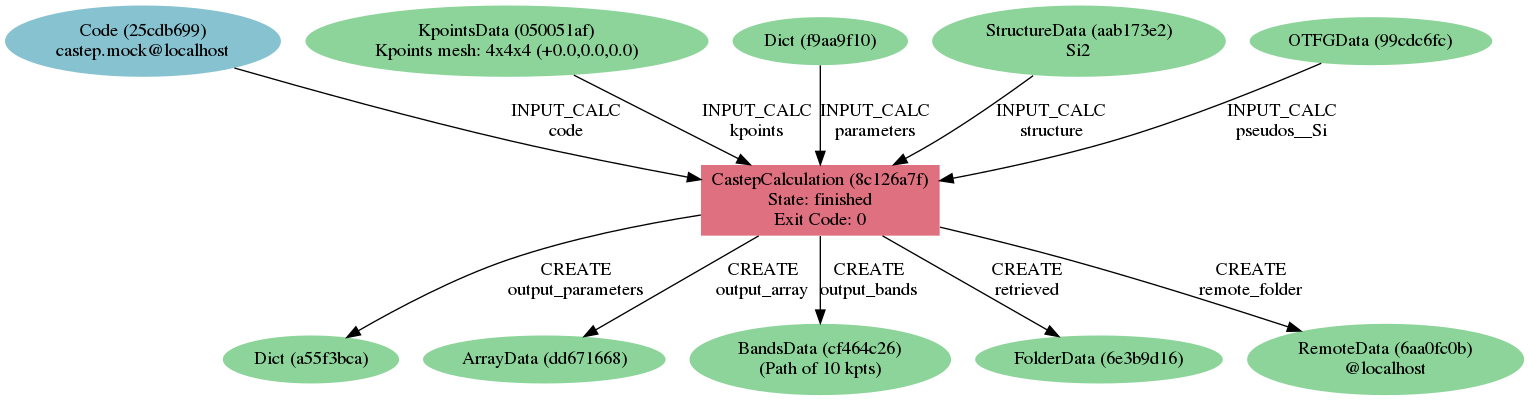

In [2]:
# A exmaple of the provenance graph of a CastepCalculation
from __future__ import print_function
from IPython.display import Image
Image("./Si_bs_example.png")

The calculations (square) take data nodes (circle) as the input and create output data nodes.
There is also a `Code` node which represents the code that is used to conduct the calculation, i.e the CASTEP executable on the remote cluster.  

## Preparing a CASTEP calculation
Here are the essential parts of a CASTEP calculations and their representation in AiiDA:
* A input structure - `StructureData`
* A set of kpoints - `KpointsData`
* A set of pseudopotentials  - `OTFGData` or `UspData` or even `UpfData`
* The parameters for calculations, e.g keys in the `param` and `cell` files - `Dict`

Below is a walk-through of the steps to create a single point calculation using the basic `CastepCalculation` class.

In [3]:
import numpy as np
import aiida.orm as orm
from pprint import pprint

## Example CASTEP calculation - silicon bandstructure
This is taken from the online tutorial.

The `cell` file contain the crystal structure and related setting.

In [4]:
!cat 'bandstructure/silicon/Si2.cell' | grep -v -e "^!"

%block lattice_cart
2.6954645 2.6954645 0.0 
2.6954645 0.0       2.6954645
0.0       2.6954645 2.6954645
%endblock lattice_cart
%block positions_frac
Si 0.00 0.00 0.00
Si 0.25 0.25 0.25
%endblock positions_frac
symmetry_generate
%block species_pot
Si Si_00.usp
%endblock species_pot
kpoint_mp_grid 4 4 4
%block bs_kpoint_path 
0.5 0.25 0.75    ! W
0.5 0.5 0.5      ! L
0.0 0.0  0.0     ! Gamma
0.5 0.0 0.5      ! X
0.5 0.25 0.75    ! W
0.375 0.375 0.75 ! K
%endblock bs_kpoint_path 


The `param` file contains a list of key-value pairs 

In [5]:
!cat 'bandstructure/silicon/Si2.param' | grep -v -e "^!"

task		bandstructure ! The TASK keyword instructs CASTEP what to do
xc_functional   LDA           ! Which exchange-correlation functional to use.
basis_precision MEDIUM        ! Choose high cut-off COARSE/MEDIUM/FINE/PRECISE
fix_occupancy   true          ! Treat the system as an insulator
opt_strategy    speed         ! Choose algorithms for best speed at expense of memory.
num_dump_cycles 0             ! Don't write unwanted ".wvfn" files.
write_formatted_density TRUE  ! Write out a density file that we can view using (e.g.) Jmol.


## Setup the calculation with AiiDA
We setup a similar calculation with Si here. Instead of going for the band structure, we just do a single point run.

### Define the structure by creating the `StructureData` node

In [6]:
# Define the structure
from aiida.plugins import DataFactory
StructureData = DataFactory('structure')
silicon = StructureData()
r_unit = 2.6954645
silicon.set_cell(np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]) * r_unit)
silicon.append_atom(symbols=["Si"], position=[0, 0, 0])
silicon.append_atom(symbols=["Si"], position=[r_unit * 0.5] * 3)
silicon.label = "Si"
silicon.description = "A silicon structure"

Atomic Simulation Environment (ASE) has a rich set of tools for handling structures, center around the `ase.Atoms` class.
They can be converted to `StructureData` that AiiDA understands and saves to the provenance graph.

In [7]:
# You can also use ase.Atoms object to create the StructureData
from ase import Atoms
silicon_atoms = Atoms('Si2', cell=silicon.cell, scaled_positions=((0, 0, 0), (0.25, 0.25, 0.25)))
silicon_from_atoms = StructureData(ase=silicon_atoms)

`StructureData` can be converted back to `Atoms` for complex operation using `ase`.

In [8]:
# You can also convent the StructureData back to ase.Atoms
silicon_atoms_2 = silicon_from_atoms.get_ase()
silicon_atoms_2 == silicon_atoms

True

Note that a similar interface also exists to work with `pymatgen`.

### Define the parameters by creating the `Dict` node
We use a nested dictionary to represent the input key-value pairs for CASTEP.
The keys for `param` file goes under `PARAM` and that for `cell` file goes under `CELL`.
Finally, we convert the dictionary to `Dict`, allowing AiiDA to store it in the database.


In [9]:
# Define a dictionary to store the parameters of the calculations
Dict = DataFactory('dict')
param_dict = {
    # Notice that the keywords are group into two sub-dictionaries
    # just like you would do when preparing the inputs by hand
    "CELL":{
        "symmetry_generate": True,
        "snap_to_symmetry": True,
        # Pass a list of string to set a BLOCK inputs
        #"cell_constraints":
        #["0 0 0", "0 0 0"]
    },
    "PARAM":{
        "task": "singlepoint",
        "basis_precision": "medium",
        "fix_occupancy": True,   # Use bool type to make it easy for querying
        "opt_strategy": "speed",
        "num_dump_cycles": 0,  
        "write_formatted_density": True
    }}
# We need to create a Dict node that holds the dictionary
param = Dict(dict=param_dict)

`Dict` type can be converted back to python dictionary.

In [10]:
# You can acceess the stored data
pprint(param.get_dict())

# You can also reset the data in the Dict node
param_dict["PARAM"].update(opt_strategy="memory")
param.set_dict(param_dict)
print(param.get_dict())
# Get it back
param_dict["PARAM"].update(opt_strategy="memory")


{'CELL': {'snap_to_symmetry': True, 'symmetry_generate': True},
 'PARAM': {'basis_precision': 'medium',
           'fix_occupancy': True,
           'num_dump_cycles': 0,
           'opt_strategy': 'speed',
           'task': 'singlepoint',
           'write_formatted_density': True}}
{'CELL': {'symmetry_generate': True, 'snap_to_symmetry': True}, 'PARAM': {'task': 'singlepoint', 'basis_precision': 'medium', 'fix_occupancy': True, 'opt_strategy': 'memory', 'num_dump_cycles': 0, 'write_formatted_density': True}}


### Define the kpoints with the `KpointsData` node
Plane-wave DFT calculations require a k-point grid. We need to define it and store the database. The `KpointData` is used for this purpose.

In [11]:
KpointsData = DataFactory('array.kpoints')
# You can define kpoints explicitly
kpoints = KpointsData()
# Use gamma and 0.25, 0.25, 0.25
kpoints.set_kpoints(((0., 0., 0), (0.25, 0.25, 0.25)), weights=[0.5, 0.5])
pprint(kpoints.get_kpoints(also_weights=True))

(array([[0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25]]), array([0.5, 0.5]))


Very often the a grid is used, the actual kpoints are computed by CASTEP taking symmetry into account.
The `KpointsData` can also represent the grid instead of explicit points.

In [12]:
# More commonly, we want to use a grid (mesh) of the kpoints
kpoints = KpointsData()
kpoints.set_kpoints_mesh((4, 4, 4), offset=(0,0,0))
print(kpoints.get_kpoints_mesh())

([4, 4, 4], [0.0, 0.0, 0.0])


### Define the pseudopotentials
Pseuodpotentials are also stored as `Node` in AiiDA and we have to define them. For CASTEP, they can be library names, on-the-fly generation strings or files.

Define an OTFG string for Si

In [13]:
from aiida_castep.data.otfg import OTFGData
from aiida_castep.data.usp import UspData
# Explicitly define the OTFG string
si_c18 = OTFGData(otfg_entry="Si 3|1.8|5|6|7|30:31:32")
# Alternatively you can define explicitly the file to be used
#si_usp = UspData(file="/home/max/MS61_00/Si_00.usp")

Alternatively, we can define a string as the name of the library.

In [14]:
c9 = OTFGData(otfg_entry="C9")

### Put things together
A calculation has a bunch of inputs which have been define above.  
It also requires other settings such as which code to use, what resources are need and for how long e.t.c.

In [15]:
from aiida.plugins import CalculationFactory

#Load up the CASTEP calculation
CastepCalculation = CalculationFactory('castep.castep')

It is most convenient to use a `ProcessBuilder` to build calculation. It provides a namespace for all the inputs and allows interactive tab completion. 

In [16]:
builder = CastepCalculation.get_builder()

In [17]:
# Uncomment the below line to create a localhost Computer if you have not done so
comp = orm.Computer('localhost', 'localhost', transport_type='core.local', scheduler_type='core.direct')
comp.store()


# Some configuration may be needed for first-time user
comp.set_workdir('/tmp/aiida_run/')
comp.configure()

It is essential that we tell AiiDA which CASTEP executable on the remote compute that we want to run.
Hence, a `Code` is required for the builder.

In [18]:
import os

In [19]:
# Define a mock code on the localhost computer
code_path = !which castep.mock
castep_mock = orm.Code((comp, code_path[0]), input_plugin_name='castep.castep')

Now, we put everything together in the `builder`

In [20]:
builder.structure = silicon
builder.parameters = param
builder.kpoints = kpoints
builder.code = castep_mock
builder.pseudos = {'Si': c9}
builder.metadata.options.withmpi = False

In [21]:
builder.metadata.options.resources = {'num_machines': 1, 'tot_num_mpiprocs': 2}
builder.metadata.options.max_wallclock_seconds = 600
builder.metadata.label = "Si SINGLEPOINT"
builder.metadata.description = 'A Example CASTEP calculation for silicon'

In [22]:
def d2attr(d, b):
    for k, v in d.items():
        b.__setattr__(k, v)

In [23]:
from aiida.engine import run_get_node
from aiida.engine import Process

In [24]:
results, calcjob  = run_get_node(builder)

In [25]:
results['retrieved'].base.repository.list_object_names()

['_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'aiida.bands',
 'aiida.castep',
 'aiida.den_fmt']

In [26]:
calcjob.base.repository.list_object_names()

['.aiida', '_aiidasubmit.sh', 'aiida.cell', 'aiida.param']

In [27]:
calcjob.inputs.structure.cell

[[2.6954645, 2.6954645, 0.0],
 [2.6954645, 0.0, 2.6954645],
 [0.0, 2.6954645, 2.6954645]]

In [28]:
calcjob.inputs.code.attributes

{'is_local': False,
 'remote_exec_path': '/home/bonan/miniconda3/envs/aiida-2.0-dev/bin/castep.mock',
 'input_plugin': 'castep.castep'}

In [29]:
print(calcjob.base.repository.get_object_content('aiida.param'))

##### Generated by aiida_castep 22:25:36 26/05/2022 BST #####
#         author: Bonan Zhu (zhubonan@outlook.com)
# # AiiDA User: user@email.com
# AiiDA profile: myprofile
# Information of the calculation node
# label: Si SINGLEPOINT
# description:
# A Example CASTEP calculation for silicon
# 
## Information of input nodes used:
# 
# type: uuid: 16b540c5-e510-4d8f-8f8f-c789b109a71e (pk: 3)
# pk: 3
# linkname: parameters
# uuid: 16b540c5-e510-4d8f-8f8f-c789b109a71e
# label: 
# description:
# 
# END OF HEADER
task                : singlepoint
basis_precision     : medium
fix_occupancy       : True
opt_strategy        : memory
num_dump_cycles     : 0
write_formatted_density: True
iprint              : 1
run_time            : 540
comment             : Si SINGLEPOINT


## Transverse the graph
We demostrate how to follow the links to get the input and output of a calculation

In [30]:
lns = calcjob.get_incoming()  # This is an link manager

In [31]:
# A link triple is a object contains the link label, vertex of the link
link = lns.first()
print(f"Link label: {link.link_label}")
print(f"Link node: {link.node}")
print(f"Link type: {link.link_type}")

Link label: pseudos__Si
Link node: uuid: e9cb672c-a8a5-4233-af2d-858f4d2ee3f1 (pk: 1)
Link type: LinkType.INPUT_CALC


In [32]:
# Get the node by the link label
print(lns.get_node_by_label('structure').__repr__())
print(lns.get_node_by_label('parameters').__repr__())

<StructureData: uuid: 2a534b89-3f0c-481b-957b-24e338f627ad (pk: 2)>
<Dict: uuid: 16b540c5-e510-4d8f-8f8f-c789b109a71e (pk: 3)>


In [33]:
# Link pair includes link type and link label
lns.all_link_pairs()

[LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='pseudos__Si'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='structure'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='parameters'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='kpoints'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='code')]

In [34]:
# Link triples also include nodes
lns.link_triples

[LinkTriple(node=<OTFGData: uuid: e9cb672c-a8a5-4233-af2d-858f4d2ee3f1 (pk: 1)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='pseudos__Si'),
 LinkTriple(node=<StructureData: uuid: 2a534b89-3f0c-481b-957b-24e338f627ad (pk: 2)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='structure'),
 LinkTriple(node=<Dict: uuid: 16b540c5-e510-4d8f-8f8f-c789b109a71e (pk: 3)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='parameters'),
 LinkTriple(node=<KpointsData: uuid: 301e225b-980c-4d98-bb32-4fcb64c13b55 (pk: 4)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='kpoints'),
 LinkTriple(node=<Code: Remote code '' on localhost, pk: 5, uuid: 73b511f7-a5f4-4396-97c5-8c248466f170>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='code')]

## Raw output file

The raw output is stored in the `retrieved` output node.

In [35]:
# The to access the output
print(calcjob.outputs.retrieved.base.repository.get_object_content("aiida.castep"))

 +-------------------------------------------------+
 |                                                 |
 |      CCC   AA    SSS  TTTTT  EEEEE  PPPP        |
 |     C     A  A  S       T    E      P   P       |
 |     C     AAAA   SS     T    EEE    PPPP        |
 |     C     A  A     S    T    E      P           |
 |      CCC  A  A  SSS     T    EEEEE  P           |
 |                                                 |
 +-------------------------------------------------+
 |                                                 |
 | Welcome to Academic Release CASTEP version 19.1 |
 | Ab Initio Total Energy Program                  |
 |                                                 |
 | Authors:                                        |
 | M. Segall, M. Probert, C. Pickard, P. Hasnip,   |
 | S. Clark, K. Refson, J. R. Yates, M. Payne      |
 |                                                 |
 | Contributors:                                   |
 | P. Lindan, P. Haynes, J. White, V. Milman, 

An result of calculation is reflected by the exit status. Like processes, zero return code means it completed without error.

In [36]:
calcjob.exit_status

0

To can the list of possible `exit_status` and they meanings, we can use `verdi plugin list`. This also shows list of inputs of which the required ones are in bold.

In [37]:
!verdi plugin list aiida.calculations castep.castep

Description:

    Class representing a generic CASTEP calculation -
    This class should work for all types of calculations.

Inputs:
           parameters:  required  Dict             A node that defines the input parameters
              pseudos:  required                   Use nodes for the pseudopotentails of one ofthe element in the structure. Y ...
            structure:  required  StructureData    The input structure
           bs_kpoints:  optional  KpointsData      Extra kpoints input for task: bandstructure
                 code:  optional  Code             The `Code` to use for this job. This input is required, unless the `remote_ ...
        elnes_kpoints:  optional  KpointsData      Extra kpoints input for task: elnes
              kpoints:  optional  KpointsData      Use a node defining the kpoints for the calculation
       magres_kpoints:  optional  KpointsData      Extra kpoints input for task: magres
             metadata:  optional                   
       optics_k

## Access the results
Results of calculation can be access in python

In [38]:
# A Dict node is created containing some of the parsed results
calcjob.outputs.output_parameters.get_dict()

{'warnings': [],
 'castep_version': '19.1',
 'unit_length': 'A',
 'unit_time': 'ps',
 'unit_energy': 'eV',
 'unit_force': 'eV/A',
 'num_ions': 2,
 'n_kpoints': '10',
 'point_group': '32: Oh, m-3m, 4/m -3 2/m',
 'space_group': '227: Fd-3m, F 4d 2 3 -1d',
 'cell_constraints': '1 1 1 0 0 0',
 'pseudo_pots': {'Si': '3|1.8|5|6|7|30:31:32'},
 'initialisation_time': 3.44,
 'calculation_time': 2.92,
 'finalisation_time': 0.02,
 'total_time': 6.38,
 'geom_unconverged': None,
 'parser_warnings': [],
 'parser_info': 'AiiDA CASTEP basic Parser v1.1.1',
 'total_energy': -337.9095600892,
 'error_messages': []}

In [39]:
# Alternatively, you can access the parsed results using
calcjob.res.castep_version   # hit tab for completion after `res`

'19.1'

In [40]:
# To get all the outgoing links and nodes
calcjob.get_outgoing().all()

[LinkTriple(node=<RemoteData: uuid: 36167374-0f02-467e-9ccb-25a6c62f27a0 (pk: 7)>, link_type=<LinkType.CREATE: 'create'>, link_label='remote_folder'),
 LinkTriple(node=<FolderData: uuid: d610ec30-f095-4018-b403-5c4ddb5aa4cb (pk: 8)>, link_type=<LinkType.CREATE: 'create'>, link_label='retrieved'),
 LinkTriple(node=<BandsData: uuid: c05a309e-706d-499c-8558-3cbe958f61da (pk: 9)>, link_type=<LinkType.CREATE: 'create'>, link_label='output_bands'),
 LinkTriple(node=<ArrayData: uuid: bae83129-6fee-44df-a8a4-d895406e6c0b (pk: 10)>, link_type=<LinkType.CREATE: 'create'>, link_label='output_array'),
 LinkTriple(node=<Dict: uuid: 2adc9560-6b1e-47d4-817a-7d6ba740b84d (pk: 11)>, link_type=<LinkType.CREATE: 'create'>, link_label='output_parameters')]

In [41]:
# Or just the nodes
calcjob.get_outgoing().all_nodes()

[<RemoteData: uuid: 36167374-0f02-467e-9ccb-25a6c62f27a0 (pk: 7)>,
 <FolderData: uuid: d610ec30-f095-4018-b403-5c4ddb5aa4cb (pk: 8)>,
 <BandsData: uuid: c05a309e-706d-499c-8558-3cbe958f61da (pk: 9)>,
 <ArrayData: uuid: bae83129-6fee-44df-a8a4-d895406e6c0b (pk: 10)>,
 <Dict: uuid: 2adc9560-6b1e-47d4-817a-7d6ba740b84d (pk: 11)>]

The actual files retrived from remote computer is stored in a `FolderData` node.

In [42]:
# The output .castep files and others are stored in the repository
calcjob.outputs.retrieved.base.repository.list_object_names()

['_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'aiida.bands',
 'aiida.castep',
 'aiida.den_fmt']

We check if the correct energy was parsed from the output `.castep` file

In [43]:
# To quickly check the output file
!echo '{calcjob.outputs.retrieved.base.repository.get_object_content('aiida.castep')}' | grep 'Final energy' 

# The parsed the total energy
print(calcjob.res.total_energy)

Final energy =  -337.9095600892     eV
-337.9095600892


So the energy matches 👏!